# LSTM on Amazon Food Reviews Dataset

In [261]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 


In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.


In [8]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
#         print(i)
#         print(sent)
        break
    i += 1

In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [14]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

## Converting AFR data into IMDB format

In [180]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

### As dataset is imbalanced, sampled equal datapoints for both the classes

In [220]:
# Sampling equal datapoints

final_balanced_reviews = final.loc[final['Score'] == 'positive'][:57000]
neg_reviews = final.loc[final['Score'] == 'negative'][:57000]
final_balanced_reviews = final_balanced_reviews.append(neg_reviews, ignore_index=True)
final_balanced_reviews = final_balanced_reviews[['Text', 'Score']]
final_balanced_reviews.head()

,Text,Score
0,this witty little book makes my son laugh at l...,positive
1,"I grew up reading these Sendak books, and watc...",positive
2,This is a fun way for children to learn their ...,positive
3,This is a great little book to read aloud- it ...,positive
4,This is a book of poetry about the months of t...,positive


### Encode the review labels into 0 or 1

In [221]:
def encode(label):
    if label == 'positive':
        return 1
    else:
        return 0
final_balanced_reviews['Score'] = final_balanced_reviews['Score'].apply(encode)
final_balanced_reviews.head()

,Text,Score
0,this witty little book makes my son laugh at l...,1
1,"I grew up reading these Sendak books, and watc...",1
2,This is a fun way for children to learn their ...,1
3,This is a great little book to read aloud- it ...,1
4,This is a book of poetry about the months of t...,1


In [222]:
final_balanced_reviews['Score'].value_counts()

1    57000
0    57000
Name: Score, dtype: int64

### Created a corpus of words to give each word a index 

In [213]:
# create a corpus of all words

review_index_set = set()
for review in final['Text']:
    for word in re.findall(r"[\w]+", review):
        review_index_set.add(word)
word_freq = FreqDist(review_index_set)


In [246]:
print(len(word_freq))
top_words = 10000
freqent_10000 = word_freq.most_common(top_words)

152739


### Selected top frequent 10k words from 152k words

In [170]:
# create a dict with index to each word:
review_index = {freqent_10000[i][0]:i for i in range(len(freqent_10000))}

### Embedded each word with an index value similar to IMDB dataset in keras, and converted the review sentence into vector of indexes

In [223]:
ind_reviews = []

for i, review in final_balanced_reviews.iterrows():
    ind_reviews_temp = []
    for word in re.findall(r"[\w]+", str(review)):
        if not word in stop and word in review_index.keys():
            ind_reviews_temp.append(review_index[word])
    if ind_reviews_temp != []:
        final_balanced_reviews.at[i, 'Text'] = ind_reviews_temp


### Below if the representation of reviews in vector form

In [226]:
final_balanced_reviews.head()

,Text,Score
0,"[1144, 4522]",1
1,"[3441, 1144]",1
2,[1144],1
3,[1144],1
4,[1144],1


### The maximum review vector length is 115

In [184]:
# print(ind_reviews)
lengths_of_list = []
for l in ind_reviews:
    lengths_of_list.append(len(l))
print(max(lengths_of_list))

115


### Split the data into train and test

In [232]:
x_train, x_test = train_test_split(final_balanced_reviews, test_size = 0.2)

In [240]:
X_train = np.array(x_train['Text'])
Y_train = np.array(x_train['Score'])

X_test = np.array(x_test['Text'])
Y_test = np.array(x_test['Score'])

In [271]:
print(X_train.shape)

(91200, 115)


### Perform padding ,so that each review vector is of uniform length i.e 115

In [245]:
# truncate and/or pad input sequences
max_review_length = 115
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(91200, 115)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1144 4522]


## Single LSTM layer architecture with batch size 64

In [247]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 115, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


In [250]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=64, validation_data=(X_test, Y_test), callbacks=[es])


Instructions for updating:
Use tf.cast instead.


C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 286s 3ms/step - loss: 0.0266 - acc: 0.9945 - val_loss: 5.0334e-04 - val_acc: 1.0000
Epoch 2/50
91200/91200 [==============================] - 189s 2ms/step - loss: 4.3762e-05 - acc: 1.0000 - val_loss: 5.1463e-04 - val_acc: 1.0000
Epoch 00002: early stopping


Test score: 0.0005146302218105248
Test accuracy: 99.99561403508773


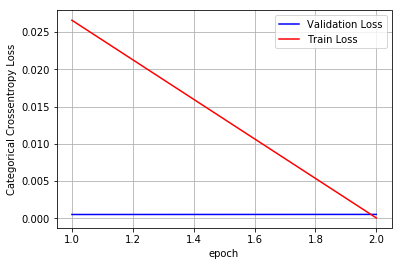

In [255]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Single LSTM layer architecture with batch size 256

In [256]:
# create the model with batch size of 256
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=256, validation_data=(X_test, Y_test), callbacks=[es])

print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 47s 514us/step - loss: 0.0895 - acc: 0.9926 - val_loss: 0.0022 - val_acc: 0.9991
Epoch 2/50
91200/91200 [==============================] - 46s 508us/step - loss: 8.5772e-04 - acc: 0.9998 - val_loss: 9.1886e-04 - val_acc: 0.9999
Epoch 3/50
91200/91200 [==============================] - 46s 507us/step - loss: 2.1468e-04 - acc: 1.0000 - val_loss: 8.8855e-04 - val_acc: 0.9999
Epoch 4/50
91200/91200 [==============================] - 47s 512us/step - loss: 9.9690e-05 - acc: 1.0000 - val_loss: 7.1318e-04 - val_acc: 1.0000
Epoch 5/50
91200/91200 [==============================] - 47s 516us/step - loss: 5.7979e-05 - acc: 1.0000 - val_loss: 6.4638e-04 - val_acc: 1.0000
Epoch 6/50
91200/91200 [==============================] - 47s 518us/step - loss: 3.7768e-05 - acc: 1.0000 - val_loss: 5.9417e-04 - val_acc: 1.0000
Epoch 7/50
91200/91200 [==============================] - 48s 521us/step - l

Test score: 0.0006232691669426633
Test accuracy: 99.99561403508773


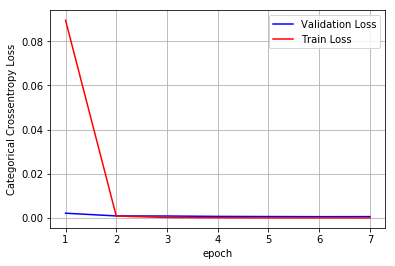

In [257]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Single LSTM layer architecture with batch size 1024

In [305]:
# create the model with batch size of 1024
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=1024, validation_data=(X_test, Y_test), callbacks=[es])
model.save('LSTM_AFR_v1.h5')
print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 26s 287us/step - loss: 0.3737 - acc: 0.9585 - val_loss: 0.0102 - val_acc: 0.9991
Epoch 2/50
91200/91200 [==============================] - 23s 258us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 3/50
91200/91200 [==============================] - 23s 248us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 4/50
91200/91200 [==============================] - 25s 275us/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0032 - val_acc: 0.9991
Epoch 5/50
91200/91200 [==============================] - 23s 249us/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0024 - val_acc: 0.9991
Epoch 6/50
91200/91200 [==============================] - 23s 249us/step - loss: 8.6729e-04 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 0.9991
Epoch 7/50
91200/91200 [==============================] - 23s 251us/step - loss: 5.8328e-04 - acc: 1.0000 - val_

Test score: 0.0016192961627159988
Test accuracy: 99.92105263157895


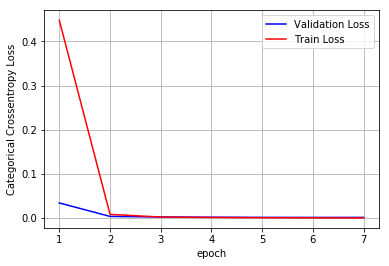

In [259]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

##  LSTM layer with relu activation

In [270]:
# create the model with batch size of 256
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, activation='relu'))
# model.add(Dropout(0.5))
# model.add(LSTM(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=1024, validation_data=(X_test, Y_test), callbacks=[es])

print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 17s 188us/step - loss: 5.6883 - acc: 0.5829 - val_loss: 7.8635 - val_acc: 0.5068
Epoch 2/50
91200/91200 [==============================] - 16s 174us/step - loss: 7.9981 - acc: 0.4983 - val_loss: 7.8635 - val_acc: 0.5068
Epoch 00002: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 115, 32)           320000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


Test score: 7.863511811975847
Test accuracy: 50.675438596491226


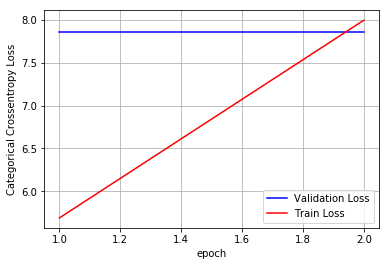

In [272]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## 2 LSTM layers architecture

In [278]:
# create the model with batch size of 256
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, input_shape=(912000, 115), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100, input_shape=(912000, 115)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=1024, validation_data=(X_test, Y_test), callbacks=[es])

print(model.summary())

C:\Users\Shubham\.conda\envs\shub\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 91200 samples, validate on 22800 samples
Epoch 1/50
91200/91200 [==============================] - 37s 408us/step - loss: 0.3680 - acc: 0.8664 - val_loss: 0.0074 - val_acc: 0.9989
Epoch 2/50
91200/91200 [==============================] - 35s 383us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0034 - val_acc: 0.9992
Epoch 3/50
91200/91200 [==============================] - 35s 385us/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0025 - val_acc: 0.9997
Epoch 4/50
91200/91200 [==============================] - 35s 386us/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.0028 - val_acc: 0.9996
Epoch 00004: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 115, 32)           320000    
_________________________________________________________________
lstm_29 (LSTM)               (None, 115, 100)          53200     
____________________________________

Test score: 0.0027767170279025376
Test accuracy: 99.96052631578948


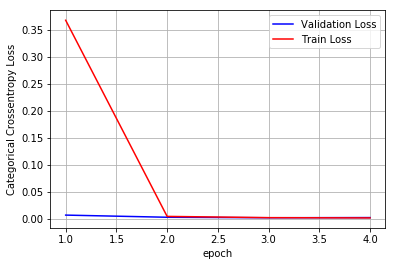

In [279]:
# Final evaluation of the model
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1]*100)
# print(history.history)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
# x = list(range(1,nb_epoch+1))
x = list(range(1,es.stopped_epoch+2))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [302]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = [' LSTM Layers','Batchsize', 'Activation', 'Dropout', "Train Accuracy", 'Test Accuracy']
x.add_row(['1', '64', "atanh", 'N','100.0','100.0'])
x.add_row(['1', '256', "atanh", "N", '100.0','100.0'])
x.add_row(['1', '1024',"atanh", "N", '100.0','99.92'])
x.add_row(['1', '1024', "relu", "N", '49.83','50.68'])
x.add_row(['2', "1024","atanh",'Y', '99.98','99.96'])
print(x)

+--------------+-----------+------------+---------+----------------+---------------+
|  LSTM Layers | Batchsize | Activation | Dropout | Train Accuracy | Test Accuracy |
+--------------+-----------+------------+---------+----------------+---------------+
|      1       |     64    |   atanh    |    N    |     100.0      |     100.0     |
|      1       |    256    |   atanh    |    N    |     100.0      |     100.0     |
|      1       |    1024   |   atanh    |    N    |     100.0      |     99.92     |
|      1       |    1024   |    relu    |    N    |     49.83      |     50.68     |
|      2       |    1024   |   atanh    |    Y    |     99.98      |     99.96     |
+--------------+-----------+------------+---------+----------------+---------------+


# Conclusions:

- Used total of 114,000 reviews from AFR dataset for this exercise.
- Balanced the dataset by taking 57k positive and 57K negative reviews.
- Converted AFR data into IMDB dataset format.
- Used index values of words to encode reviews into vectors.
- With single layer of accuarcy I am getting 100% accuracy.
- atanh activation performs better then relu in this case.
- Used return_sequences=True for 2 layers of LSTM.